In [1]:
%cd /home/smalani/Cybernetic

from growth import parFun as growth_parFun
from growth import odeFun as growth_odeFun
import numpy as np

from gardner_opto import pulse_integrator
import matplotlib.pyplot as plt
import numpy as np


/home/smalani/Cybernetic


In [2]:
def RK4_int(fun, t_span, y0, pars=None, t_step=0.1):
    if pars is None:
        int_fun = lambda t,y: fun(t,y)
    else:
        int_fun = lambda t,y: fun(t,y,*pars)

a = RK4_int(growth_odeFun, [0,100], 0, pars=growth_parFun())

In [104]:
def myf_small(var, pulse_on, pulse_period):
    if pulse_on > pulse_period:
        raise ValueError('pulse_period cannot be less than pulse_on')
    tau_off=30
    tau_on=5
    n=4

    pulse_off = pulse_period - pulse_on

    var_dark = var

    for i in range(1):

        pulse_fun = lambda x: (x ** n) / (x ** n + tau_on ** n) - var_dark
        # t_status = fsolve(pulse_fun, 0) % pulse_period
        # if pulse_on < pulse_period and pulse_on > 0:
        sol = root_scalar(pulse_fun, bracket=[0, 100000])
        t_status = sol.root
        # else:
        #     t_status = 0

        var_light = (pulse_on + t_status) ** n / ((pulse_on + t_status) ** n + tau_on ** n)

        var_dark = var_light * np.exp(-(pulse_off / tau_off))

    return var_dark - var

def trans_mean_func(u, period):
    sol = root_scalar(myf_small, bracket=[0,1], args=(period*u,period))
    if u > 0:
        t_step = min(period/1000,period*u)
    else:
        t_step = period/1000
    t_out, act_out, light_out, light_time_out = pulse_integrator(pulse_on=u*period, 
                                                             pulse_period=period, 
                                                             t_start=0, 
                                                             t_end=period, 
                                                             act_init=sol.root, 
                                                             t_step=t_step)

    act_mean = np.trapz(act_out, t_out) / period
    return act_mean



u = 0.01
period = 100


print(trans_mean_func(u, period))
    

0.005692071795204232


0.0010451694484451964
-0.0033277839454767255


In [22]:
alpha_e= 0.01 /10
alpha_star_e = 0.001 /10
beta_e = 0.002 /10

alpha_p = 0.01
beta_p = 0.0002

K_p = 0.1

t_frac = 1

u_arr = [0, 1., 0.]



def steady_state(act_mean):
    e0 = (alpha_e*act_mean + alpha_star_e) / beta_e
    # p0 = alpha_p * e0 / beta_p
    # p0 = e0 * alpha_p / (beta_p * (K_p + e0))
    p0 = (alpha_e*act_mean + alpha_star_e) / beta_e
    E0 = e0 * beta_e / (alpha_e + alpha_star_e)
    return [E0, p0]


def enzyme_fun_light(t, vars, alpha_fun, u_fun, period):
    E, p = vars

    e = E * (alpha_e + alpha_star_e) / beta_e


    dedt = alpha_e * alpha_fun(t) - beta_e * e + alpha_star_e
    # dpdt = alpha_p * e - beta_p * p

    dEdt = dedt * beta_e / (alpha_e + alpha_star_e)
    dpdt = dEdt

    return [dEdt, dpdt]

print(steady_state(0))



[0.09090909090909091, 0.5]


In [16]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve, root_scalar

def myf_small(var, pulse_on, pulse_period):
    if pulse_on > pulse_period:
        raise ValueError('pulse_period cannot be less than pulse_on')
    tau_off=30
    tau_on=5
    n=4

    pulse_off = pulse_period - pulse_on

    var_dark = var

    for i in range(1):

        pulse_fun = lambda x: (x ** n) / (x ** n + tau_on ** n) - var_dark
        # t_status = fsolve(pulse_fun, 0) % pulse_period
        if pulse_on < pulse_period and pulse_on > 0:
            sol = root_scalar(pulse_fun, bracket=[0, 100000])
            t_status = sol.root
        else:
            t_status = 0

        var_light = (pulse_on + t_status) ** n / ((pulse_on + t_status) ** n + tau_on ** n)

        var_dark = var_light * np.exp(-(pulse_off / tau_off))

    return var_dark - var

# pulse_on = 100
# pulse_period = 100

t_span = [0,1000*t_frac]
u = u_arr[0]
period = 100
u0 = 0.5
# [0.3476345637700329]

# u = 0.056
# period = 50
# # [0.3426074974759692]

# u = 0.05
# period = 10
# # [0.334279394092861]
# u0 = 0.5

# u = 0.3
# period = 1000
# # [0.3245610831875518]
# u0 = 0.01

u0, infodict, ier, mesg = fsolve(myf_small, u0, full_output=True, args=(period*u,period))


print(u0)
print(mesg)
# u0 = 0.5

t_out_arr, act_out_arr, light_out_arr, light_time_out_arr = [], [], [], []
t_out, act_out, light_out, light_time_out = pulse_integrator(pulse_on=u*period, 
                                                             pulse_period=period, 
                                                             t_start=t_span[0], 
                                                             t_end=t_span[1], 
                                                             act_init=u0, 
                                                             t_step=0.1)
t_out_arr.append(t_out)
act_out_arr.append(act_out)
light_out_arr.append(light_out)
light_time_out_arr.append(light_time_out)

print('shapity shape')
period_len = int(act_out.size / (t_span[1] / period))
act_mean = np.trapz(act_out[-period_len:], t_out[-period_len:],) / period
print(act_mean)

for i in range(len(u_arr) - 1):

    t_span = np.array([0,30000*t_frac]) + t_span[-1]
    u = u_arr[i+1]
    period = 100
    u0 = act_out[-1]
    t_out, act_out, light_out, light_time_out = pulse_integrator(pulse_on=u*period, 
                                                                pulse_period=period, 
                                                                t_start=t_span[0], 
                                                                t_end=t_span[1], 
                                                                act_init=u0, 
                                                                t_step=0.1)
    t_out_arr.append(t_out)
    act_out_arr.append(act_out)
    light_out_arr.append(light_out)
    light_time_out_arr.append(light_time_out)

t_out = np.concatenate(t_out_arr)
act_out = np.concatenate(act_out_arr)
light_out = np.concatenate(light_out_arr)
light_time_out = np.concatenate(light_time_out_arr)

alpha1_fun = interp1d(t_out, act_out)
zero_line = np.zeros(light_time_out.shape)



# e0 = [(alpha*u0 + alpha_star) / beta]
# e0 = (alpha_e*act_mean + alpha_star_e) / beta_e
# p0 = alpha_p * e0 / beta_p
# e0 = [400]
e0, p0 = steady_state(act_mean)

t_span = [0,t_span[1]]

sol = solve_ivp(enzyme_fun, t_span, [e0, e0], args=(alpha1_fun,), 
                    rtol=1e-12, atol=1e-15, 
                    method='BDF',
                    first_step=0.1,
                )
    

[0.]
The solution converged.
shapity shape
0.0


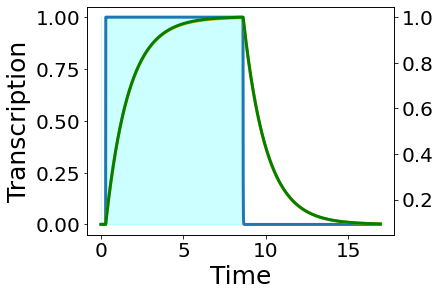

In [17]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(t_out/60/60, act_out, linewidth=3)
ax.fill_between(light_time_out/60/60, light_out, zero_line, color='cyan', alpha=0.2)
ax.set_ylabel('Transcription', fontsize=25)
ax.set_xlabel('Time', fontsize=25)
ax.tick_params(axis='both', labelsize =20)
# ax.set_yticks(fontsize=20)

ax2 = ax.twinx()
ax2.plot(sol.t/60/60, sol.y[0], c='orange', linewidth=3)
ax2.plot(sol.t/60/60, (sol.y[1])/(max(sol.y[1])), c='green', linewidth=3)
# ax2.set_ylim([-0.1,1.1])
ax2.tick_params(axis='both', labelsize =20)

0.09090909090909091
